# 版本说明v4 #
1. 使用LinearRegressor
2. 使用pipeline
3. 添加自定义的Transformer，可以选择指定的成分
4. 针对各个参数进行了调优
5. 封装了工具方法
6. 是mse作为scoring

# 拆分训练集和验证集 #

In [7]:
from hw1_utils_v5 import *
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

X_train_full,y_train_full,X_test,test_options = load_data() # 加载训练和测试数据

n_features = X_train_full.shape[1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
X_train_fullt

In [3]:
# 重新排序一下
X_train_full = X_train_full.reindex(np.random.RandomState(0).permutation(X_train_full.index))

In [4]:
X_train_full.index = range(X_train_full.shape[0]) # 重新生成一下index

# 使用LinearRegression模型 ##

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def rmse_cross_val_score(model,X,y):
    return cross_val_score(model,X,y,scoring='neg_root_mean_squared_error').mean() * -1
    
rmse_cross_val_score(LinearRegression(),X_train_full,y_train_full)

16.86591832711061

## 有用的方法 ##
**删除无关测项**   
1. 将所有feature放进去，计算cv_score，记录为best score
2. 然后分别减掉一个feature，选出最高的cv_score，如果，如果比best_score，那么去掉这个feature
3. 然后重复上面的操作，直到最高的score不再比best_score高为止。  

**嵌入法**：threshold = 0.0111   

## 被排除的方法如下：##
**方差过滤**：基本没有影响   
**F值过滤**：最大的p也只有e-26   
**互信息法**：没有可以删除的feature   
**分箱法**：没有用   

In [6]:
from sklearn.pipeline import Pipeline

options = SelectTestOptionTransformer()
pipeline = Pipeline(steps=[('options',options),
                           ('model',LinearRegression())])
options.exclude = []

train_best_scores = []
valid_best_scores = []
exclude_params = [] # 已经被排除的测项
best_score = -16.86591832711061
flag = True
while flag:
    # 将已经排除的加上一个新的测项，作为本次遍历的已排除测项
    param_range = [exclude_params + [test_options[i]] for i in range(18)]
    
    train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                                 'options__exclude',param_range,
                                                 scoring='neg_root_mean_squared_error')
    
    valid_score = valid_scores.mean(axis=1)              # 取验证集每个feature的平均分
    valid_max = valid_score.max()                        # 取出最高分
    valid_argmax = valid_score.argmax()                  # 最高分对应的feature值
    train_max = train_scores.mean(axis=1)[valid_argmax]  # 该feature在训练集的分数作为训练集最高分
    
    if valid_max > best_score:
        train_best_scores.append(train_max)
        valid_best_scores.append(valid_max)
        best_score = valid_max
        if len(valid_score) > 1:
            test_option_killed = test_options[valid_argmax]
            exclude_params.append(test_option_killed)
        print('剔除{}后，训练集得分为{:.4f}，验证集得分为{:.4f}'.format(
            test_option_killed,train_max,valid_max))
            
    else:
        print('剔除完成。')
        flag = False

剔除RAINFALL后，训练集得分为-16.2968，验证集得分为-16.8321
剔除NO后，训练集得分为-16.3120，验证集得分为-16.7990
剔除PM2.5后，训练集得分为-16.3316，验证集得分为-16.7682
剔除O3后，训练集得分为-16.3449，验证集得分为-16.7386
剔除NO2后，训练集得分为-16.3605，验证集得分为-16.7111


KeyboardInterrupt: 

## 噪音过滤后的学习曲线 ##

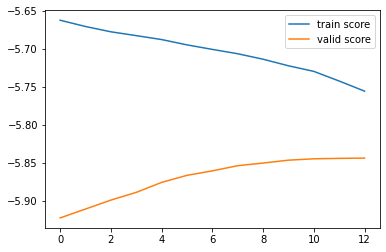

In [167]:
def plot_best_scores():
    x = len(train_best_scores)
    plt.plot(range(x),train_best_scores,label='train score')
    plt.plot(range(x),valid_best_scores,label='valid score')
    plt.legend()
    plt.show()
    
plot_best_scores()

In [168]:
best_score * (-1)

5.8438056886500584

# 标准化 

In [263]:
from sklearn.preprocessing import StandardScaler

exclude_params = ['RH', 'AMB_TEMP', 'NO', 'THC', 'NMHC', 'WIND_DIREC', 
                  'WD_HR', 'WS_HR', 'WIND_SPEED', 'NOx', 'RAINFALL', 
                  'CO', 'CH4']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('model',LinearRegression())])

cross_val_score(pipeline,X_data,y_train_full,n_jobs=-1,
                scoring='neg_root_mean_squared_error').mean() * (-1)

5.843805688650058

# 方差过滤 #
**总结**：方差过滤没有影响

In [267]:
from sklearn.feature_selection import VarianceThreshold

exclude_params = ['RH', 'AMB_TEMP', 'NO', 'THC', 'NMHC', 'WIND_DIREC', 
                  'WD_HR', 'WS_HR', 'WIND_SPEED', 'NOx', 'RAINFALL', 
                  'CO', 'CH4']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('vt',VarianceThreshold()),
                           ('model',LinearRegression())])

In [269]:
treshold_range = [0.01 * i for i in range(20)]

train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                             'vt__threshold',treshold_range,
                                             scoring='neg_root_mean_squared_error')

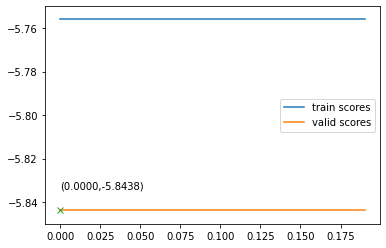

(0.0, -5.843805688650058)

In [270]:
plot_validation_curve(train_scores,valid_scores,treshold_range,ylim=(-5.85,-5.75))

# F值过滤 #
**总结**：p值基本都等于0，虽然学习曲线44的时候值最大，但是把cv调到10之后，33的是最大，存在很大的随机性，而且数字差别也不大，暂时不用F值过滤

In [172]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

exclude_params = ['RH', 'AMB_TEMP', 'NO', 'THC', 'NMHC', 'WIND_DIREC', 
                  'WD_HR', 'WS_HR', 'WIND_SPEED', 'NOx', 'RAINFALL', 
                  'CO', 'CH4']

X_data = SelectTestOptionTransformer(exclude_params).fit_transform(X_train_full)
X_data.shape # 过滤后数据的维度

(5652, 45)

In [174]:
from sklearn.feature_selection import f_regression
X_data_f,X_data_p = f_regression(X_data,y_train_full) 

(X_data_p < 0.01).sum() # 剩下的feature都和结果相关

45

In [193]:
X_data_p.sum() # 最大的一个p

2.3927173845344613e-26

In [271]:
pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('f',SelectKBest(f_regression)),
                           ('model',LinearRegression())])
train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                             'f__k',range(1,46),n_jobs=-1,
                                             error_score=0,verbose=1,cv=5,
                                             scoring='neg_root_mean_squared_error')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   15.6s finished


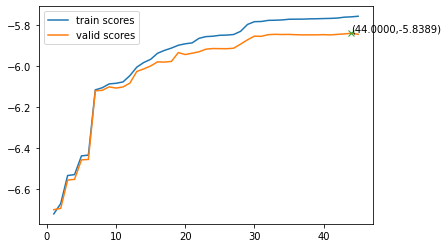

(44, -5.838936668264827)

In [272]:
plot_validation_curve(train_scores,valid_scores,range(1,46))

# 互信息法

In [285]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression


exclude_params = ['RH', 'AMB_TEMP', 'NO', 'THC', 'NMHC', 'WIND_DIREC', 
                  'WD_HR', 'WS_HR', 'WIND_SPEED', 'NOx', 'RAINFALL', 
                  'CO', 'CH4']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('mir',SelectKBest(mutual_info_regression)),
                           ('model',LinearRegression())])

train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                             'mir__k',range(1,46),n_jobs=-1,
                                             error_score=0,verbose=1,cv=5,
                                             scoring='neg_root_mean_squared_error')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  4.6min finished


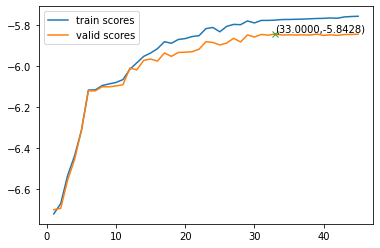

(33, -5.842794594122543)

In [274]:
plot_validation_curve(train_scores,valid_scores,range(1,46)) # 符合预期，没有元素可以删除

# 嵌入法

In [282]:
from sklearn.feature_selection import SelectFromModel

exclude_params = ['RH', 'AMB_TEMP', 'NO', 'THC', 'NMHC', 'WIND_DIREC', 
                  'WD_HR', 'WS_HR', 'WIND_SPEED', 'NOx', 'RAINFALL', 
                  'CO', 'CH4']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('mir',SelectKBest(mutual_info_regression,k=33)),
                           ('sfm',SelectFromModel(LinearRegression())),
                           ('model',LinearRegression())])

train_scores,valid_scores = validation_curve(pipeline,X_data,y_train_full,
                                             'sfm__threshold',np.linspace(0,0.02,10),
                                             scoring='neg_root_mean_squared_error')

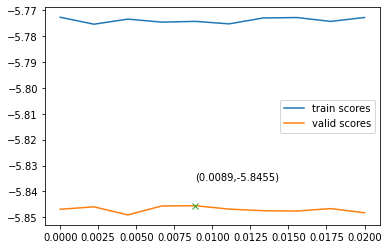

(0.008888888888888889, -5.84550739492217)

In [283]:
plot_validation_curve(train_scores,valid_scores,np.linspace(0,0.02,10))

# 分一下箱 

In [279]:
exclude_params = ['RH', 'AMB_TEMP', 'NO', 'THC', 'NMHC', 'WIND_DIREC', 
                  'WD_HR', 'WS_HR', 'WIND_SPEED', 'NOx', 'RAINFALL', 
                  'CO', 'CH4']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('sfm',SelectFromModel(LinearRegression(),0.0111)),
                           ('kb',KBinsDiscretizer()),
                           ('model',LinearRegression())])

In [280]:
train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                             'kb__n_bins',range(2,20,2),
                                             scoring='neg_root_mean_squared_error')

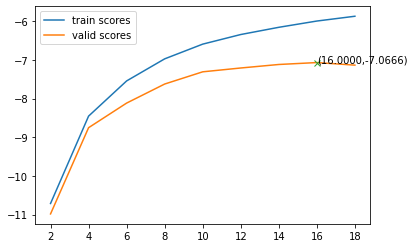

(16, -7.066577354023723)

In [281]:
plot_validation_curve(train_scores,valid_scores,range(2,20,2))

# 输出数据 #

In [284]:
exclude_params = ['RH', 'AMB_TEMP', 'NO', 'THC', 'NMHC', 'WIND_DIREC', 
                  'WD_HR', 'WS_HR', 'WIND_SPEED', 'NOx', 'RAINFALL', 
                  'CO', 'CH4']
pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('mir',SelectKBest(mutual_info_regression,k=33)),
                           ('sfm',SelectFromModel(LinearRegression(),0.0098)),
                           ('model',LinearRegression())])

pipeline.fit(X_train_full,y_train_full)

preds_test = pipeline.predict(X_test)
ids = ['id_' + str(i) for i in range(len(X_test))]
output = pd.DataFrame({'id':ids,
                           'value':preds_test})
output.to_csv('output/pm25_submission.csv',index=False)